Этот ноутбук сделан для запуска обучения альтернативной сверточной нейронной сети.

In [18]:
#!g1.1
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import scipy.stats as sps
#import imageio
#import seaborn as sns
import os
import time

from sklearn.model_selection import train_test_split

from collections import defaultdict

import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

import nn_architectures
import nn_tools
import data_load

import warnings
warnings.filterwarnings('ignore')

#sns.set(font_scale=1.3)
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 24
plt.rcParams['axes.titlesize'] = 36
plt.rcParams['axes.labelsize'] = 24

## 1. Подготовка данных

In [2]:
#!g1.1
data = data_load.load_dataset('./data_part/')
data.head()

,PupX,PupY,PupR,IriX,IriY,IriR,1,2,3,4,...,631,632,633,634,635,636,637,638,639,640
Filename,,,,,,,,,,,,,,,,,,,,,
2463(r-1-1)101231-233000_e_00_0000.bmp,391,263,45,392,263,121,0,0,0,0,...,1651,1665,1637,1596,1496,1400,1212,1012,801,607
2463(r-1-1)101231-233000_e_00_0001.bmp,392,261,37,396,261,120,0,0,0,0,...,2639,2544,2358,2119,1893,1707,1972,2235,2490,2753
2463(r-1-1)101231-233000_e_00_0002.bmp,385,270,36,389,270,120,0,0,0,0,...,2014,1835,1721,1688,1628,1629,1927,2254,2625,3028
2463(r-1-1)101231-233000_e_00_0003.bmp,292,273,34,296,273,120,0,0,0,0,...,1594,1800,1977,2195,2338,2451,2269,2027,1746,1433
2463(r-1-1)101231-233000_e_00_0004.bmp,363,262,38,367,262,119,1017,1017,1017,1017,...,1820,1782,1746,1708,1668,1662,1489,1281,1024,807


In [3]:
#!g1.1
sample = data[np.arange(1, 641)].to_numpy().reshape(-1, 2, 320) / 9500
target = data[['PupR', 'IriR']].to_numpy()

In [4]:
#!g1.1
train_sample, test_sample, train_target, test_target = train_test_split(
    sample, target, test_size=0.2, random_state=42
)
train_sample, val_sample, train_target, val_target = train_test_split(
    train_sample, train_target, test_size=1/5, random_state=42
)

In [5]:
#!g1.1
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
batch_size = 128

In [6]:
#!g1.1
class SimpleDataset(torch.utils.data.Dataset):
    def __init__(self, data, target):
        super(SimpleDataset, self).__init__()
        
        assert data.shape[0] == target.shape[0]
        self.data = data
        self.target = target
        
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        return torch.FloatTensor(self.data[idx]), torch.FloatTensor(self.target[idx])

In [7]:
#!g1.1
train_dataset = SimpleDataset(train_sample, train_target)
train_generator = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = SimpleDataset(val_sample, val_target)
val_generator = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataset = SimpleDataset(test_sample, test_target)
test_generator = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

## 2. Обучение

In [11]:
#!g1.1
class Convolutional(nn.Module):
    """
        Нейронная сеть с применением сверточных слоев
    """

    def __init__(self):
        super(Convolutional, self).__init__()

        self.conv1 = nn_architectures.ConvBlock(2, 8, 3, 1, 1)
        self.conv2 = nn_architectures.ConvBlock(8, 16, 5, 2, 2)
        self.conv3 = nn_architectures.ConvBlock(16, 32, 5, 2, 2)
        self.conv4 = nn_architectures.ConvBlock(32, 64, 5, 2, 2)
        self.conv5 = nn_architectures.ConvBlock(64, 5, 2, 2)
        self.flat = nn.Flatten()
        self.linear6 = nn_architectures.LinearBlock(100, 30)
        self.linear7 = nn.Linear(30, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.linear6(self.flat(x))
        x = self.linear7(x)

        return x

In [12]:
#!g1.1
def conv2_train_iter(exec_no):
    net = Convolutional().to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=3e-3)
    history = nn_tools.train(
        net, criterion, optimizer,
        train_generator,
        val_generator,
        num_epochs=200,
        device=device,
        save_path='out/conv2/{}.model'.format(exec_no),
        ylim_loss=(0, 20), ylim_mape=(0, 0.1)
    )
    return history

Time elapsed: 0.416s


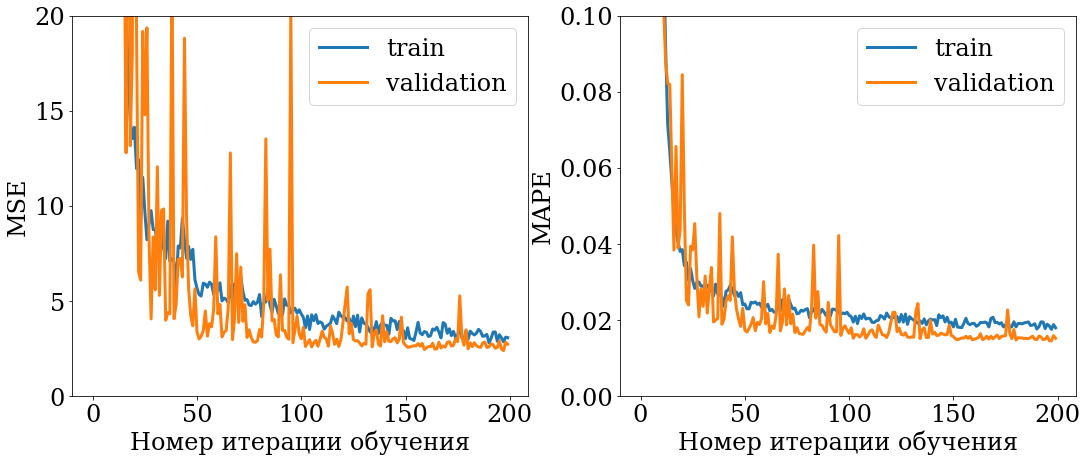

In [13]:
#!g1.1
history = nn_tools.accumulate_histories(conv2_train_iter, num_executions=50)
torch.save(history, 'out/conv2/history')

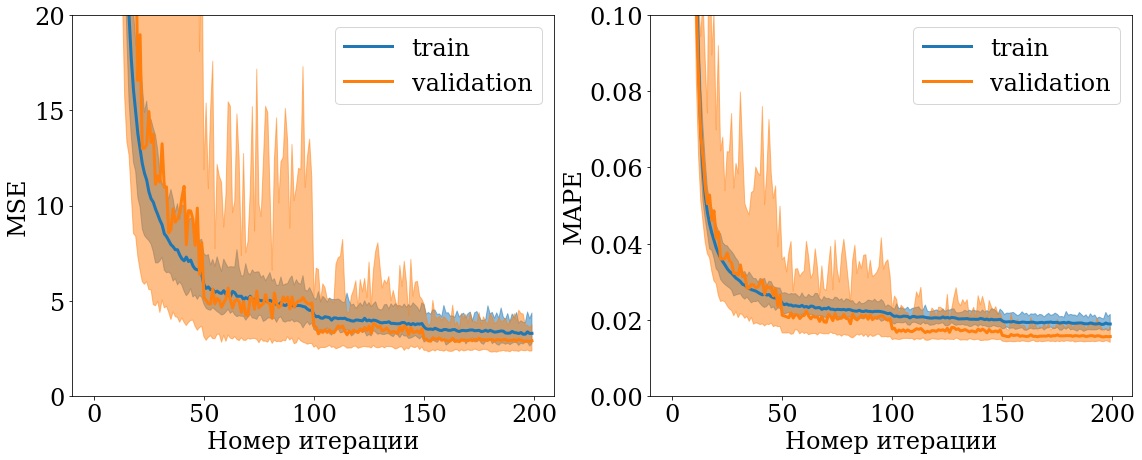

In [19]:
#!g1.1
nn_tools.visualize_histories(history, q=(0.025, 0.975), figsize=(19, 7), ylim_loss=(0, 20), ylim_mape=(0, 0.1))

In [22]:
#!g1.1
import subprocess

In [23]:
#!g1.1
subprocess.check_output("tar -zcvf ./out_conv2.tar.gz ./out/conv2/", shell=True)

b'./out/conv2/\n./out/conv2/24.model\n./out/conv2/9.model\n./out/conv2/14.model\n./out/conv2/47.model\n./out/conv2/28.model\n./out/conv2/41.model\n./out/conv2/19.model\n./out/conv2/34.model\n./out/conv2/49.model\n./out/conv2/32.model\n./out/conv2/27.model\n./out/conv2/48.model\n./out/conv2/3.model\n./out/conv2/33.model\n./out/conv2/45.model\n./out/conv2/35.model\n./out/conv2/11.model\n./out/conv2/4.model\n./out/conv2/43.model\n./out/conv2/10.model\n./out/conv2/13.model\n./out/conv2/16.model\n./out/conv2/21.model\n./out/conv2/22.model\n./out/conv2/30.model\n./out/conv2/15.model\n./out/conv2/23.model\n./out/conv2/44.model\n./out/conv2/2.model\n./out/conv2/39.model\n./out/conv2/46.model\n./out/conv2/0.model\n./out/conv2/37.model\n./out/conv2/8.model\n./out/conv2/29.model\n./out/conv2/38.model\n./out/conv2/36.model\n./out/conv2/12.model\n./out/conv2/31.model\n./out/conv2/history\n./out/conv2/7.model\n./out/conv2/42.model\n./out/conv2/25.model\n./out/conv2/40.model\n./out/conv2/18.model\n./